<a href="https://colab.research.google.com/github/JimenaBaripatti/FeatureEngineering/blob/main/Fire_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feature Selection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# setting up libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import statistics
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency
from scipy import stats
import math
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from textblob import TextBlob

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import joblib
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
#from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline


# Setting working directory
#os.chdir("/content/drive/MyDrive/Colab Notebooks/Data/")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [3]:
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Functions

In [4]:
# numerical correlation
def plot_pearson_correlation(df, cols, low_thres, high_thres):
    # customized
    
    corr_df = df[cols].corr()
    # Get only half portion of corr_df to avoid df, so create mask    
    mask = np.triu(np.ones_like(corr_df), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(corr_df, vmin=-1, vmax=1, cbar=False,
                     cmap='coolwarm', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if low_thres < t < high_thres:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks( size='x-large')
    plt.yticks(rotation=0, size='x-large')
    # Save fig uncomment first
    # plt.savefig("Heatmap DF")
    plt.show()
    return corr_df

In [5]:
# select highly correlated numerical features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [6]:
def check_categorical_dependency(crosstab_table, confidence_interval):
    stat, p, dof, expected = stats.chi2_contingency(crosstab_table)
    print ("Chi-Square Statistic value = {}".format(stat))
    print ("P - Value = {}".format(p))
    alpha = 1.0 - confidence_interval
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
	      print('Independent (fail to reject H0)')
    return expected

# Load Complete Fire Data


In [24]:
train=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/current_dataset/final_train.csv', index_col=[0])
test=pd.read_csv('https://raw.githubusercontent.com/JimenaBaripatti/FeatureEngineering/main/data/current_dataset/final_test.csv',index_col=[0])

In [16]:
len(train.columns)

77

In [25]:
keep_cols = ['LABEL','Count_of_Persons_Rescued','Number_of_responding_apparatus','Number_of_responding_personnel',
             'TFS_Firefighter_Casualties','IS_WEEKEND','MONTH','MINUTES_TO_ARRIVE','MINUTES_TO_LEAVE',
 'INCIDENT_PERIOD_NUM','IS_HOLIDAY','IS_HOLIDAY_LAG1','IS_HOLIDAY_LEAD1','IS_HOLIDAY_SEASON',
 'rain_v','snow_v','snow_on_ground_v','temperature_avg',
 'relative_humidity_avg','wind_speed_avg','density',
 'poor_building_condition','condo_dwelling','Average_Age',
 'Median_Age','male', 'Estimated_Number_Of_Persons_Displaced_imputed',
 'min_dist_to_hydrant_imputed','DISTANCE_INCIDENT_FIRESTATION_imputed',
 #'Property_Use_imputed',
 'Estimated_Dollar_Loss_imputed',
 #'Level_Of_Origin_encoded',
# 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_imputed',
 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe',
# 'Smoke_Spread_imputed',
 'Smoke_Spread_woe',
# 'Level_Of_Origin_encoded_imputed',
 'Level_Of_Origin_encoded_woe',
# 'Extent_Of_Fire_imputed',
 'Extent_Of_Fire_woe','t0','t1','t2','t3','t4', 
 'Building_Status', 'Business_Impact', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Method_Of_Fire_Control',
       'Possible_Cause', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival']

In [26]:
df_train=train.drop([col for col in train.columns if col not in keep_cols],axis=1)
#df_test=df_test.drop(cols_to_drop,axis=1)

In [13]:
#df_train=df_train.set_index('Incident_Numberinc_')

In [27]:
df_train.head(2)

,Building_Status,Business_Impact,Count_of_Persons_Rescued,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,LABEL,IS_WEEKEND,MONTH,MINUTES_TO_ARRIVE,MINUTES_TO_LEAVE,INCIDENT_PERIOD_NUM,IS_HOLIDAY,IS_HOLIDAY_LAG1,IS_HOLIDAY_LEAD1,IS_HOLIDAY_SEASON,rain_v,snow_v,snow_on_ground_v,temperature_avg,relative_humidity_avg,wind_speed_avg,density,poor_building_condition,condo_dwelling,Average_Age,Median_Age,male,Estimated_Number_Of_Persons_Displaced_imputed,min_dist_to_hydrant_imputed,DISTANCE_INCIDENT_FIRESTATION_imputed,Estimated_Dollar_Loss_imputed,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe,Smoke_Spread_woe,Level_Of_Origin_encoded_woe,Extent_Of_Fire_woe,t0,t1,t2,t3,t4
0,01 - Normal (no change),2 - May resume operations within a week,0,01 - Fire,9 - Undetermined,1 - Fire alarm system operated,1 - Fire alarm system present,1 - Extinguished by fire department,8,27,20 - Design/Construction/Installation/Maintenance Deficiency,9 - Floor/suite of fire origin: Smoke alarm presence undetermined,98 - Not applicable: Alarm operated OR presence/operation undetermined,9 - Type undetermined,3 - Did not activate: fire too small to trigger system,1 - Full sprinkler system present,2 - Fire with no evidence from street,0,0,0,5,3.983,222.500,4,0,0,0,0,2.07,0.00,0.0,11.065,61.980,16.185,20466.15,0.040702,0.573736,36.6,32.0,0.527962,3.0,19.981228,13681.310558,10000.0,1.160798,0.679226,0.881393,0.644495,0.514684,0.159836,0.028584,0.028623,0.268272
1,08 - Not Applicable,8 - Not applicable (not a business),0,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)",Not applicable,8 - Not applicable (no system),2 - No Fire alarm system,NaN,2,8,NaN,Not applicable,98 - Not applicable: Alarm operated OR presence/operation undetermined,8 - Not applicable - no smoke alarm or presence undetermined,8 - Not applicable - no sprinkler system present,9 - Undetermined,Not applicable,0,0,0,12,5.017,2.517,5,0,0,0,0,1.03,0.87,4.2,-2.445,76.695,17.660,17131.80,0.104803,0.065049,39.7,38.0,0.524255,17.0,36.546116,13680.235952,750.0,-2.197231,-2.197231,-0.893688,-1.515563,0.703259,0.033333,0.033384,0.196690,0.033333


In [28]:
df_train.shape[1]

53

In [29]:
cat_columns=df_train.select_dtypes(include=['object']).columns
num_columns=[col for col in df_train.columns if col not in cat_columns]

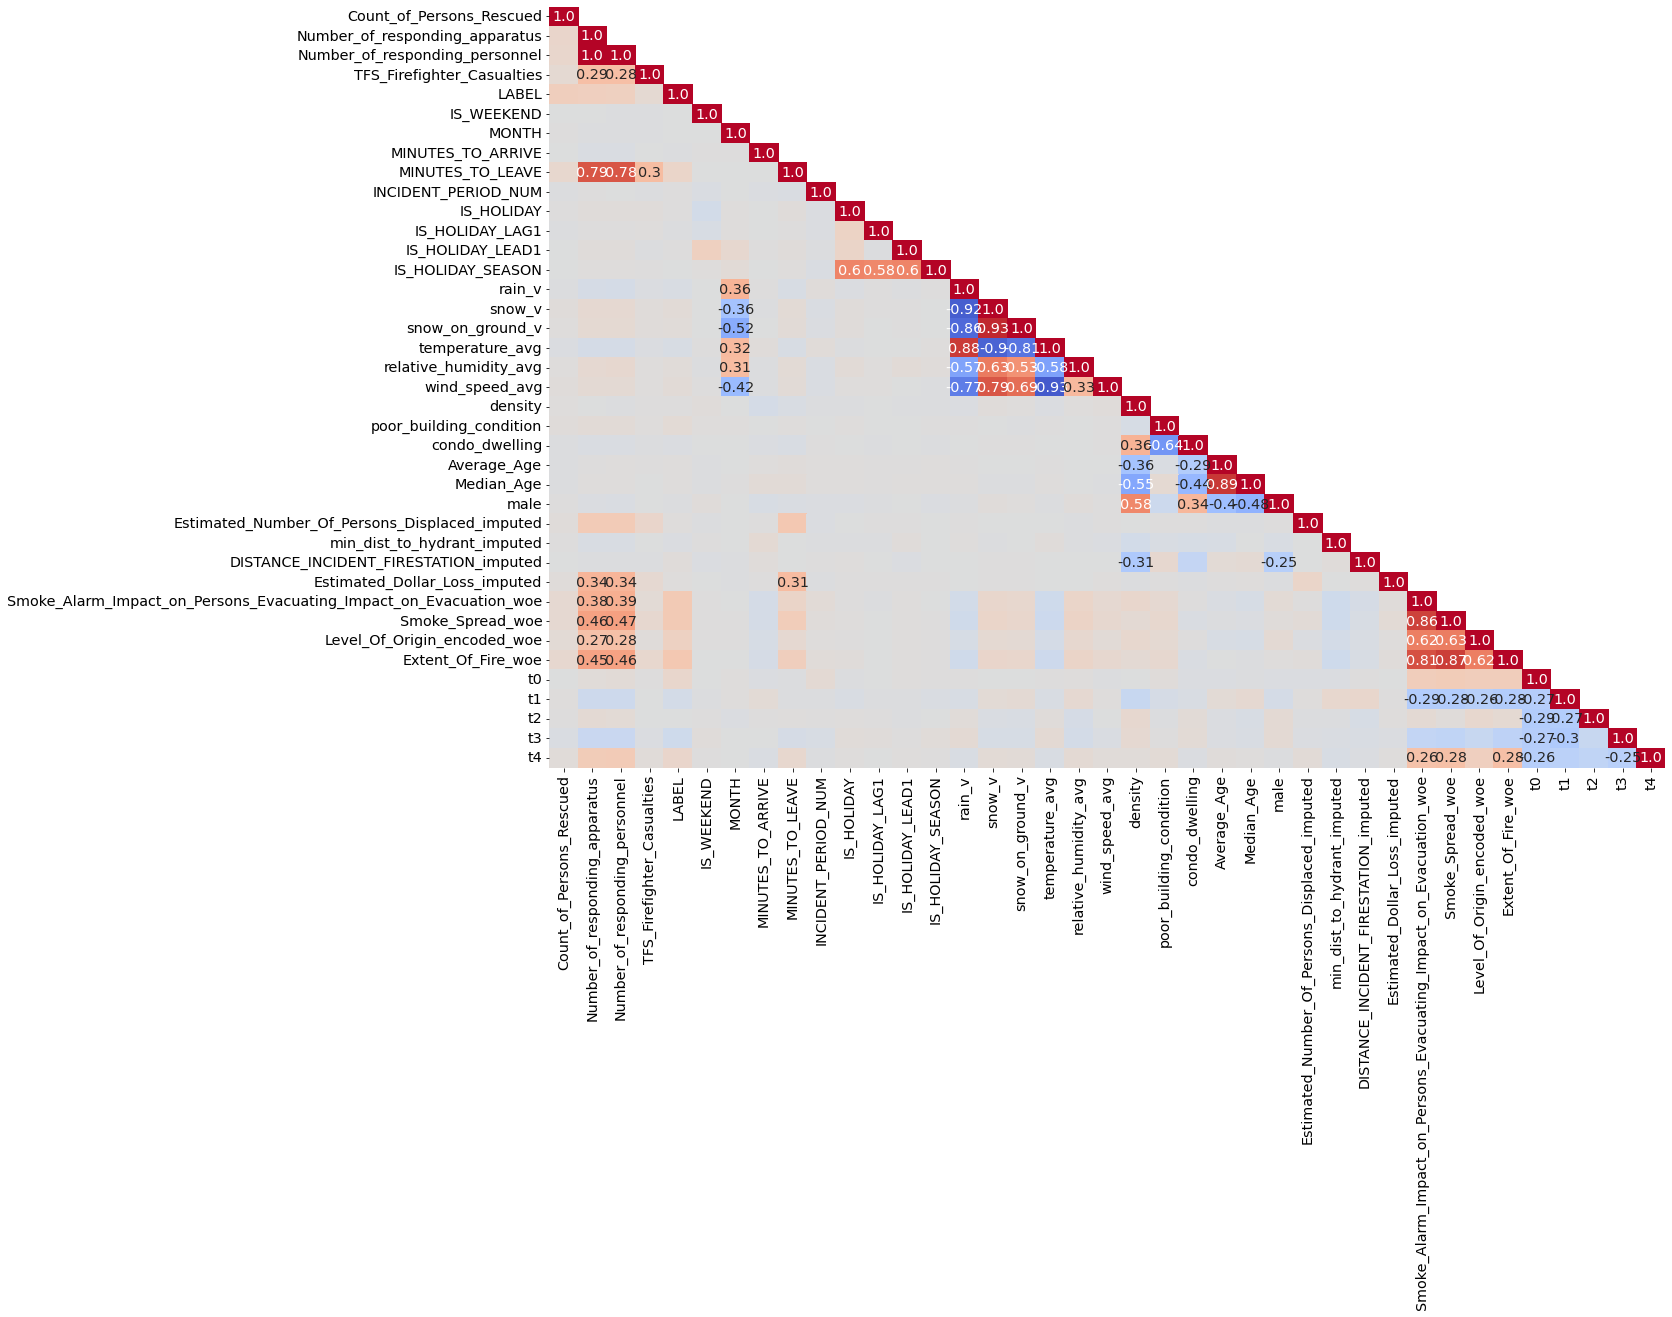

In [30]:
# Pearson
corr_num = plot_pearson_correlation(df_train, list(num_columns), -0.25, 0.25)

In [33]:
# call the function and pass the threshold
corr_num_features = correlation(df_train[num_columns], 0.6)

In [34]:
corr_num_features

{'Extent_Of_Fire_woe',
 'Level_Of_Origin_encoded_woe',
 'MINUTES_TO_LEAVE',
 'Median_Age',
 'Number_of_responding_personnel',
 'Smoke_Spread_woe',
 'condo_dwelling',
 'relative_humidity_avg',
 'snow_on_ground_v',
 'snow_v',
 'temperature_avg',
 'wind_speed_avg'}

Categorical features: chi-square

In [35]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in cat_columns:
    df_train[feat] = le.fit_transform(df_train[feat].astype(str)).astype(str)

In [36]:
y_train=df_train['LABEL']
X_train=df_train[[col for col in list(df_train.columns) if col!='LABEL']]

In [37]:
len(cat_columns)

14

In [38]:
# import the required functions and object.
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# change this to how much features you want to keep from the top ones.
#select_k = 10

# apply the chi2 score on the data and target (target should be binary).  
selection = SelectKBest(chi2, k='all').fit(X_train[cat_columns], y_train)

# display the k selected features.
cat_features = X_train[cat_columns].columns[selection.get_support()]
cat_feature_score=selection.scores_
print(cat_features, cat_feature_score)

Index(['Building_Status', 'Business_Impact', 'Final_Incident_Type',
       'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
       'Fire_Alarm_System_Presence', 'Method_Of_Fire_Control',
       'Possible_Cause', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival'],
      dtype='object') [1.12151634e+03 2.88551002e+01 1.65283933e+02 3.98825245e+02
 8.37861255e+01 1.89213481e+01 4.99455446e+01 1.68715792e+02
 3.73596861e+02 1.43615318e+00 1.56757483e+02 7.10946353e-01
 3.12501246e+01 4.16293397e+02]


In [39]:
chi_result=list(zip(cat_features,cat_feature_score))
cat_chi_scores=pd.DataFrame(chi_result,columns=['cat_features','score'])

In [40]:
cat_chi_scores.sort_values(by='score')

,cat_features,score
11,Sprinkler_System_Operation,0.710946
9,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,1.436153
5,Fire_Alarm_System_Presence,18.921348
1,Business_Impact,28.855100
12,Sprinkler_System_Presence,31.250125
6,Method_Of_Fire_Control,49.945545
4,Fire_Alarm_System_Operation,83.786125
10,Smoke_Alarm_at_Fire_Origin_Alarm_Type,156.757483
2,Final_Incident_Type,165.283933
7,Possible_Cause,168.715792


In [52]:
feature_crosstab = pd.crosstab(df_train['Building_Status'], df_train['LABEL'], 
                                       margins=True)
feature_crosstab

LABEL,0,1,All
Building_Status,,,
0,7129,703,7832
1,367,21,388
2,123,3,126
3,12,0,12
4,46,2,48
5,5506,48,5554
6,62,6,68
All,13245,783,14028


In [53]:
check_categorical_dependency(feature_crosstab, 0.95)

Chi-Square Statistic value = 410.4671611436479
P - Value = 7.891642466125454e-79
Dependent (reject H0)


array([[7.39484175e+03, 4.37158255e+02, 7.83200000e+03],
       [3.66343028e+02, 2.16569718e+01, 3.88000000e+02],
       [1.18967066e+02, 7.03293413e+00, 1.26000000e+02],
       [1.13301967e+01, 6.69803251e-01, 1.20000000e+01],
       [4.53207870e+01, 2.67921300e+00, 4.80000000e+01],
       [5.24399273e+03, 3.10007271e+02, 5.55400000e+03],
       [6.42044482e+01, 3.79555175e+00, 6.80000000e+01],
       [1.32450000e+04, 7.83000000e+02, 1.40280000e+04]])

No categorical variables to drop

# Drop correlated column(s)

In [54]:
filter_col=list(corr_num_features)#+list(chi_features_to_drop)

In [55]:
df_train.drop(labels=filter_col, axis=1, inplace=True)

In [56]:
df_train.columns

Index(['Building_Status', 'Business_Impact', 'Count_of_Persons_Rescued',
       'Final_Incident_Type', 'Fire_Alarm_System_Impact_on_Evacuation',
       'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence',
       'Method_Of_Fire_Control', 'Number_of_responding_apparatus',
       'Possible_Cause', 'Smoke_Alarm_at_Fire_Origin',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Failure',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Sprinkler_System_Operation',
       'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival',
       'TFS_Firefighter_Casualties', 'LABEL', 'IS_WEEKEND', 'MONTH',
       'MINUTES_TO_ARRIVE', 'INCIDENT_PERIOD_NUM', 'IS_HOLIDAY',
       'IS_HOLIDAY_LAG1', 'IS_HOLIDAY_LEAD1', 'IS_HOLIDAY_SEASON', 'rain_v',
       'density', 'poor_building_condition', 'Average_Age', 'male',
       'Estimated_Number_Of_Persons_Displaced_imputed',
       'min_dist_to_hydrant_imputed', 'DISTANCE_INCIDENT_FIRESTATION_imputed',
       'Estimated_Dollar_Loss_imputed',
       'Smoke_Ala

In [57]:
cat_columns=df_train.select_dtypes(include=['object']).columns
num_columns=[col for col in df_train.columns if col not in cat_columns]

# Forward Selection

In [58]:
#temperarily drop column with null value
df_train=df_train[df_train.columns[~df_train.isnull().any()]]

In [59]:

# Encode Categorical Columns
le =preprocessing.LabelEncoder()
for feat in cat_columns:
    df_train[feat] = le.fit_transform(df_train[feat].astype(str)).astype(str)


In [60]:
df_train['LABEL'].value_counts()

0    13245
1    783  
Name: LABEL, dtype: int64

In [61]:
# dominant category is 'no casulaty'
casualty=df_train[df_train['LABEL']==1]
no_casualty=df_train[df_train['LABEL']==0]
# upsampling
casualty = casualty.sample(no_casualty.shape[0],replace=True)
no_casualty.shape, casualty.shape

((13245, 41), (13245, 41))

In [62]:
#re-balanced data
df_train=no_casualty.append(casualty,ignore_index=True)
df_train['LABEL'].value_counts()

1    13245
0    13245
Name: LABEL, dtype: int64

In [65]:
y_train=df_train['LABEL']
X_train=df_train[[col for col in list(df_train.columns) if col!='LABEL']]
# create the SequentialFeatureSelector object, and configure the parameters.

#clf = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=2021)
clf = RandomForestClassifier(random_state=2021,max_depth=5)
sfs = SFS(clf,
           k_features=10,
           forward=True,
           floating=False,
           scoring = 'roc_auc',
           cv = 0)

# fit the object to the training data.
sfs = sfs.fit(np.array(X_train), y_train)

# print the selected features.
selected_features = X_train.columns[list(sfs.k_feature_idx_)]
print(selected_features)

# print the final prediction score.
print(sfs.k_score_)

Index(['Count_of_Persons_Rescued', 'Method_Of_Fire_Control',
       'Number_of_responding_apparatus', 'Possible_Cause',
       'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
       'Estimated_Number_Of_Persons_Displaced_imputed',
       'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation_woe',
       't0', 't2', 't3'],
      dtype='object')
0.8919236373591123


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


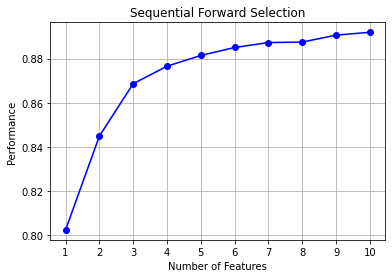

In [66]:
fig = plot_sfs(sfs.get_metric_dict())
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

# Embedded Method: Tree-Based Feature Importance

In [67]:
# create the random forest with your hyperparameters.
model = RandomForestClassifier(n_estimators=100, random_state=2021)

# fit the model to start training.
model.fit(np.array(X_train), y_train)

# get the importance of the resulting features.
importances = model.feature_importances_

# create a data frame for visualization.
final_df = pd.DataFrame({"Features": X_train.columns, "Importances":importances})
final_df.set_index('Importances')

# sort in ascending order to better visualization.
final_df = final_df.sort_values('Importances', ascending = False)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


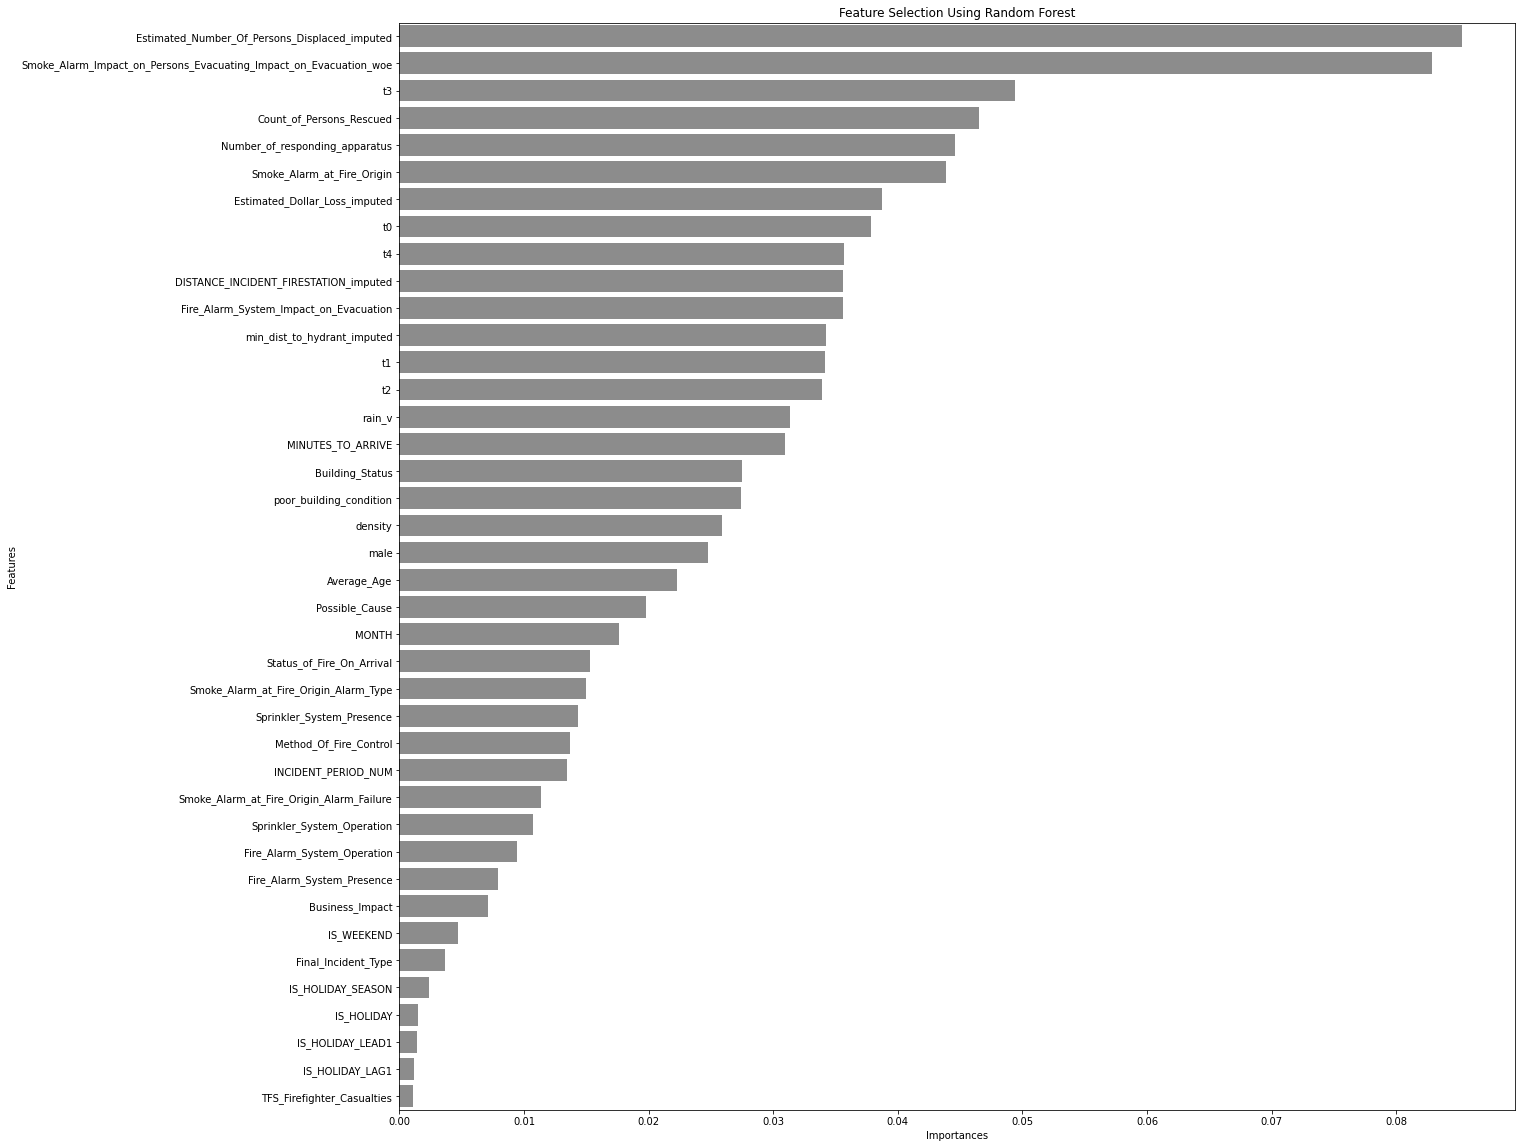

In [68]:
# plot the feature importances in bars.
#final_df.plot.bar()
plt.figure(figsize=(20,20))
fig=sns.barplot(final_df['Importances'], final_df['Features'], alpha=0.9, color="Grey")
plt.title('Feature Selection Using Random Forest')
plt.show()